# Projet : Paris smart-city

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
#%autoreload 2

import re
from collections import Counter

import folium

In [2]:
df = pd.read_csv('p2-arbres-fr.csv', delimiter = ';')

#### 1. Présentation et nettoyage des données

In [3]:
if 'type_emplacement' in df.columns:
    df.drop(columns=['type_emplacement', 'numero', 'id_emplacement', 'complement_addresse'], inplace=True)
    df.variete = df.variete.fillna('Manquante')
    df['variete'] = df['variete'].apply(lambda x: x[:-1] if x.endswith("'") else x)
    df_brut = df.copy()
    # debatable
    df = df.dropna(subset=['domanialite'])
    df.remarquable = df.remarquable.apply(lambda x : 1 if x == 1 else 0)



    hauteur_reccord = 31
    circonference_reccord = 700

    df_sans_outlier_hauteur = df.loc[df.hauteur_m <= hauteur_reccord, :]
    df_sans_outlier = df_sans_outlier_hauteur.loc[df_sans_outlier_hauteur.circonference_cm <= circonference_reccord, :]
    df_sans_outlier.head()

#### 2. Analyse

* Taux d\'arbre remarquable pour les 10 genres d\'arbres les plus plantés dans Paris

In [4]:
remarquable_per_genre_df = df.groupby(['genre'])['remarquable'].sum().sort_values(ascending=False)
remarquable_per_genre_df = remarquable_per_genre_df[remarquable_per_genre_df>=5]
temp_serie = df[df['genre'].isin(remarquable_per_genre_df[remarquable_per_genre_df > 0].index)]\
.genre.value_counts().sort_values(ascending=False)
print('Taux d\'arbre remarquable pour les 10 genres d\'arbres les plus plantés dans Paris')

percentage_remarquable_df = pd.DataFrame(remarquable_per_genre_df.div(temp_serie)*100, columns = ['%'],\
             index=temp_serie.sort_values(ascending=False).index).head(10)
percentage_remarquable_df["nombre d'arbre par genre"] = temp_serie
percentage_remarquable_df["nombre d'arbre remarquable par genre"] = remarquable_per_genre_df

percentage_remarquable_df


Taux d'arbre remarquable pour les 10 genres d'arbres les plus plantés dans Paris


,%,nombre d'arbre par genre,nombre d'arbre remarquable par genre
genre,,,
Platanus,0.075133,42591,32
Aesculus,0.039462,25341,10
Acer,0.032483,18471,6
Quercus,0.282995,3887,11
Corylus,0.202137,3463,7
Fagus,0.622084,1929,12
Pterocarya,0.700000,1000,7
Ginkgo,0.851064,940,8
Cedrus,0.878156,911,8


L'échantillon étant très faible, le maximum d'arbre remarquable par genre d'arbre étant 32 platanes, si on veut maximiser les chances de produires des arbres remarquable à Paris il peut être intéressant de planter l'un de ces genres d'abres qui ne sont pas des cas isolés (au moins 5 instances d'arbre remarquable recensés).


On ne peut pas se contenter de dire qu'il faut planter un maximum de Diospyros pour maximiser ces chances, les Platanus, les Quercus et les Fagus semblent également être préférable car l'échantillon d'arbre de ces genres présent à Paris est important et ils sont qualifiés de remarquables à une fréquence intéressante.

* Domanialite / genre

Chaque genre d'arbre va avoir un espace vert de prédilection, on met à disposition des équipes un dictionnaire indiquant la domanialite dans laquelle elle est le plus présente.

In [5]:
max_values_dict = {genre: max_value for genre, max_value in df.groupby('genre')['domanialite'].max().items()}
print({i: max_values_dict[i] for i in list(max_values_dict.keys())[:5]})

{'Abelia': 'Jardin', 'Abies': 'Jardin', 'Acacia': 'Jardin', 'Acca': 'CIMETIERE', 'Acer': 'PERIPHERIQUE'}


* hauteur/circonference et stade de developpement

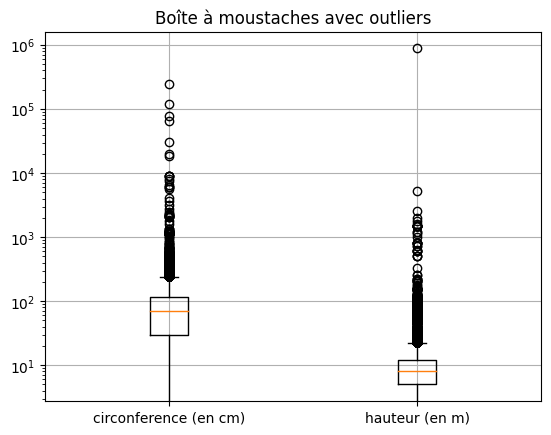

In [6]:
circonference = df['circonference_cm']
hauteur = df['hauteur_m']
plt.boxplot([circonference, hauteur], showfliers=True)
plt.xticks([1, 2], ['circonference (en cm)', 'hauteur (en m)'])
plt.yscale('log')
plt.title("Boîte à moustaches avec outliers")
plt.grid(True)
plt.show()

On définit le reccord de l'arbre le plus grand en taille et circonférence et on retire les valeurs au dessus

In [7]:
hauteur_reccord = 31
circonference_reccord = 700

df_sans_outlier_hauteur = df.loc[df.hauteur_m <= hauteur_reccord, :]
df_sans_outlier = df_sans_outlier_hauteur.loc[df_sans_outlier_hauteur.circonference_cm <= circonference_reccord, :]

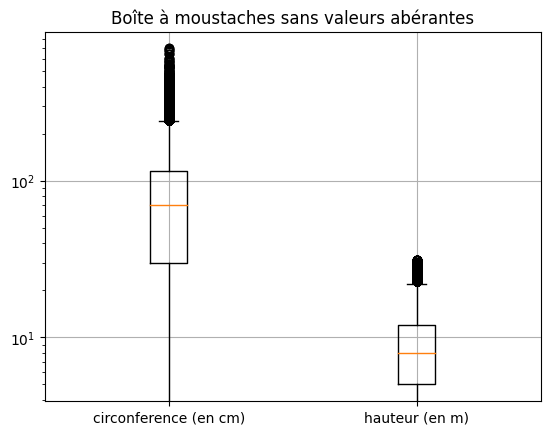

In [8]:
circonference = df_sans_outlier['circonference_cm']
hauteur = df_sans_outlier['hauteur_m']
plt.boxplot([circonference, hauteur], showfliers=True)
plt.xticks([1, 2], ['circonference (en cm)', 'hauteur (en m)'])
plt.yscale('log')
plt.title("Boîte à moustaches sans valeurs abérantes")
plt.grid(True)
plt.show()

On va pouvoir maintenant se servir des données hauteur et circonférence pour établir certains processus de renouvellement des arbres.

In [9]:
print(round((1-df['stade_developpement'].dropna().shape[0]/df['stade_developpement'].shape[0])*100,1)
      ,'% de valeurs manquantes dans "stade_developpement"')

33.6 % de valeurs manquantes dans "stade_developpement"


Il y a beaucoup de valeurs manquantes dans cette colonne, elle va être difficilement exploitable. Il faut soit établir une stratégie d'imputation pour compléter les valeurs manquantes, soit abandonner cette colonne.

In [10]:
remarquable_per_genre_df = df_sans_outlier.groupby(['genre'])['remarquable'].sum().sort_values(ascending=False)
remarquable_per_genre_df = remarquable_per_genre_df[remarquable_per_genre_df>1]
temp_serie = df_sans_outlier[df_sans_outlier['genre'].isin(remarquable_per_genre_df[remarquable_per_genre_df > 0].index)]\
.genre.value_counts().sort_values()
print("Part d'arbres remarquables parmi les différents genres.")

pd.DataFrame(remarquable_per_genre_df.div(temp_serie)*100, columns = ['%'],\
             index=temp_serie.sort_values(ascending=False).index)

Part d'arbres remarquables parmi les différents genres.


,%
genre,
Platanus,0.061282
Aesculus,0.039537
Acer,0.032531
Sophora,0.016933
Pinus,0.082406
Celtis,0.048792
Quercus,0.257865
Corylus,0.202488
Ulmus,0.140713


On va appliquer une méthode d'imputation pour les cinq premiers arbres de la liste ci-dessus. En effet les arbres remarquables faussent les stats, il est donc préférable d'étudier un échantillon avec un faible taux d'arbres remarquables.

In [11]:
def attribuer_stade_arbre(espece, taille, circonference):
    if espece == 'Platanus':
        if taille <= 10:
            return 'J'
        elif 10 < taille <= 20:
            return 'JA'
        elif 20 < taille <= 25:
            return 'A'
        else:
            return 'M'
    elif espece == 'Aesculus':
        if taille <= 10 and circonference <= 100:
            return 'J'
        elif 10 < taille <= 20 and 60 < circonference <= 200:
            return 'JA'
        elif 15 < taille <= 35 and 100 < circonference <= 400:
            return 'A'
        else:
            return 'M'
    elif espece == 'Acer' or espece == 'Sophora':
        if taille <= 8 and circonference <= 30:
            return 'J'
        elif 8 < taille <= 15 and 30 < circonference <= 100:
            return 'JA'
        elif 15 < taille <= 25 and 100 < circonference <= 200:
            return 'A'
        else:
            return 'M'
    elif espece == 'Pinus':
        if taille <= 5 and circonference <= 15:
            return 'J'
        elif 5 < taille <= 15 and 15 < circonference <= 30:
            return 'JA'
        elif 15 < taille <= 45 and 30 < circonference <= 100:
            return 'A'
        else:
            return 'M'


In [12]:
df2 = df.copy()
df2['stade_developpement'] = df2.apply(lambda row: attribuer_stade_arbre(row['genre'], row['hauteur_m'], row['circonference_cm']), axis=1)

* Analyse de la colonne lieu

In [13]:
def extract_location_ml(location):
    stopwords = set(['DU', 'DE', 'DES', 'LE', 'LA', 'LES', 'UN', 'UNE', 'ET', 'CS', 'D', 'L', 'ST', 'PTE'])

    filtered_words = [word.upper() for word in re.findall(r'\b[A-Za-z]+\b', location) if word.upper() not in stopwords]
    word_counts = Counter(filtered_words)
    most_common_word = word_counts.most_common(1)
    if most_common_word:
        return most_common_word[0][0]
df['type_de_lieu'] = df['lieu'].apply(extract_location_ml)

lieux_fréquents_df = df.type_de_lieu.value_counts().reset_index().rename(\
                            columns={'count':"nombre_d'arbres"})
lieux_fréquents_df.head(16)

,type_de_lieu,nombre_d'arbres
0,CIMETIERE,31861
1,AVENUE,30814
2,RUE,28826
3,BOULEVARD,23736
4,PARC,14749
5,SQUARE,13040
6,JARDIN,9153
7,PLACE,7606
8,TALUS,5384
9,ROUTE,4544


On vérifie que chaque arbre du DaTaframe à bien été intégré à la démarche

In [14]:
lieux_fréquents_df["nombre_d'arbres"].sum() == df.shape[0]

True

Testé avec plusieurs exemples et vérification des 100 valeurs les plus communes

In [15]:
'RUES' in lieux_fréquents_df.type_de_lieu.to_list()

False

On a bien vérifier que Counter ignore naturellement les mots au pluriel, on ne retrouve pas dans les valeurs à la fois RUE et RUES par exemple.

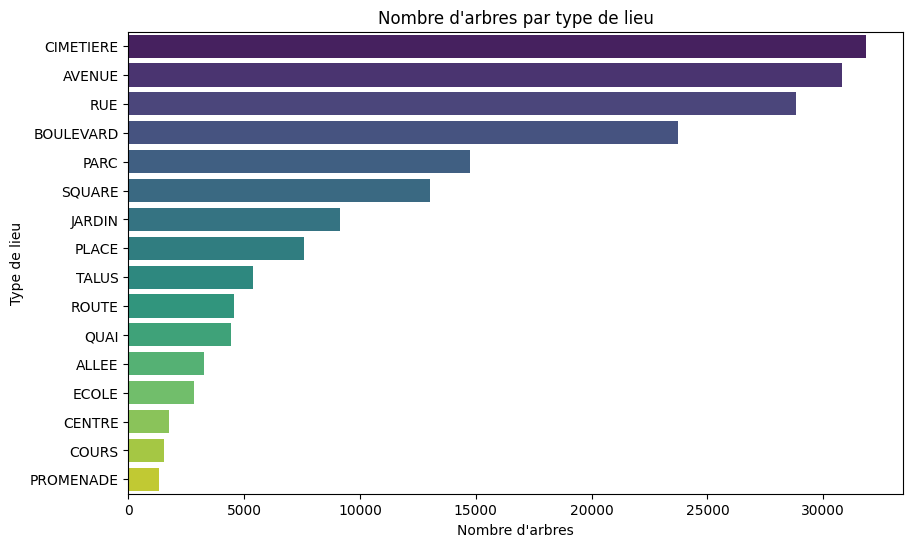

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x="nombre_d'arbres", y='type_de_lieu', data=lieux_fréquents_df.head(16)) #hue='type_de_lieu',  palette='viridis'
plt.xlabel("Nombre d'arbres")
plt.ylabel('Type de lieu')
plt.title("Nombre d'arbres par type de lieu")
plt.show()

* Outil de cartographie

In [35]:
def map_from_gps_columns(df_x=df.iloc[200:214].geo_point_2d_a,
                         df_y=df.iloc[200:214].geo_point_2d_b,
                         centre=[df.geo_point_2d_a.mean(), df.geo_point_2d_b.mean()],
                         # existing icon option or Custom one
                         icon='cloud', #icon 'cloud'
                         zoom_start = 12,
                         street_view = False):

    if street_view == False :
        m = folium.Map(location = centre, zoom_start = zoom_start, tiles='CartoDB positron', icon=icon)
    else :
        m = folium.Map(location = centre, zoom_start = zoom_start, icon=icon)

    for i in range(len(df_x)):
        folium.Marker(location=[df_x.iloc[i], df_y.iloc[i]]).add_to(m)
    return m


Mise à disposition d'un outil permettant de visualiser la position de nombreux arbres sur une carte, sur la machine de test
l'affichage rencontre des difficultés autours des 2000 arbres affichés.

dans cet exemple d'illustration on affiche plus de 300 abres présents dans les crèches de Paris, on pourrait regarder
si certaines crèches avec cours extérieures n'en possèdent pas, ou pas assez par rapport à l'espace dont elles disposent 
pour en planter de nouveaux et inspirer les futures générations !

In [36]:
x_serie = df[df.type_de_lieu == 'CRECHE']['geo_point_2d_a']
y_serie = df[df.type_de_lieu == 'CRECHE']['geo_point_2d_b']
map_from_gps_columns(x_serie,y_serie, zoom_start = 12)